This project aims to develop a predictive model identifying customers at high risk of churning the company. The model will identify the key indicators of churn and the retention strategies that can be implemented.

##### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import seaborn as sns

# Training and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler

# saving
import joblib
import pickle

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Import Dataset

df = pd.read_csv(r"C:\Users\Harrison\Downloads\Customer churn\data\raw_churn_data.csv")

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


##### Data Inspection and Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.shape

(7043, 21)

The raw dataset contains 7,043 rows and 21 columns

In [5]:
# Check the data type
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We can noticed that TotalCharges has the wrong datatype. We will modify it to the right dtype

In [6]:
# change the data type of MonthlyCharges  from object to numeric

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
# Verify
df["TotalCharges"].dtypes

dtype('float64')

In [8]:
# Check for duplicate
df.duplicated().any().sum()

0

Our data contains no duplicate

In [9]:
# Check the number unique values in each features
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

We can see the unique values in each column

In [10]:
# Check for missing values
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Our data has 11 missing values in TotalCharges

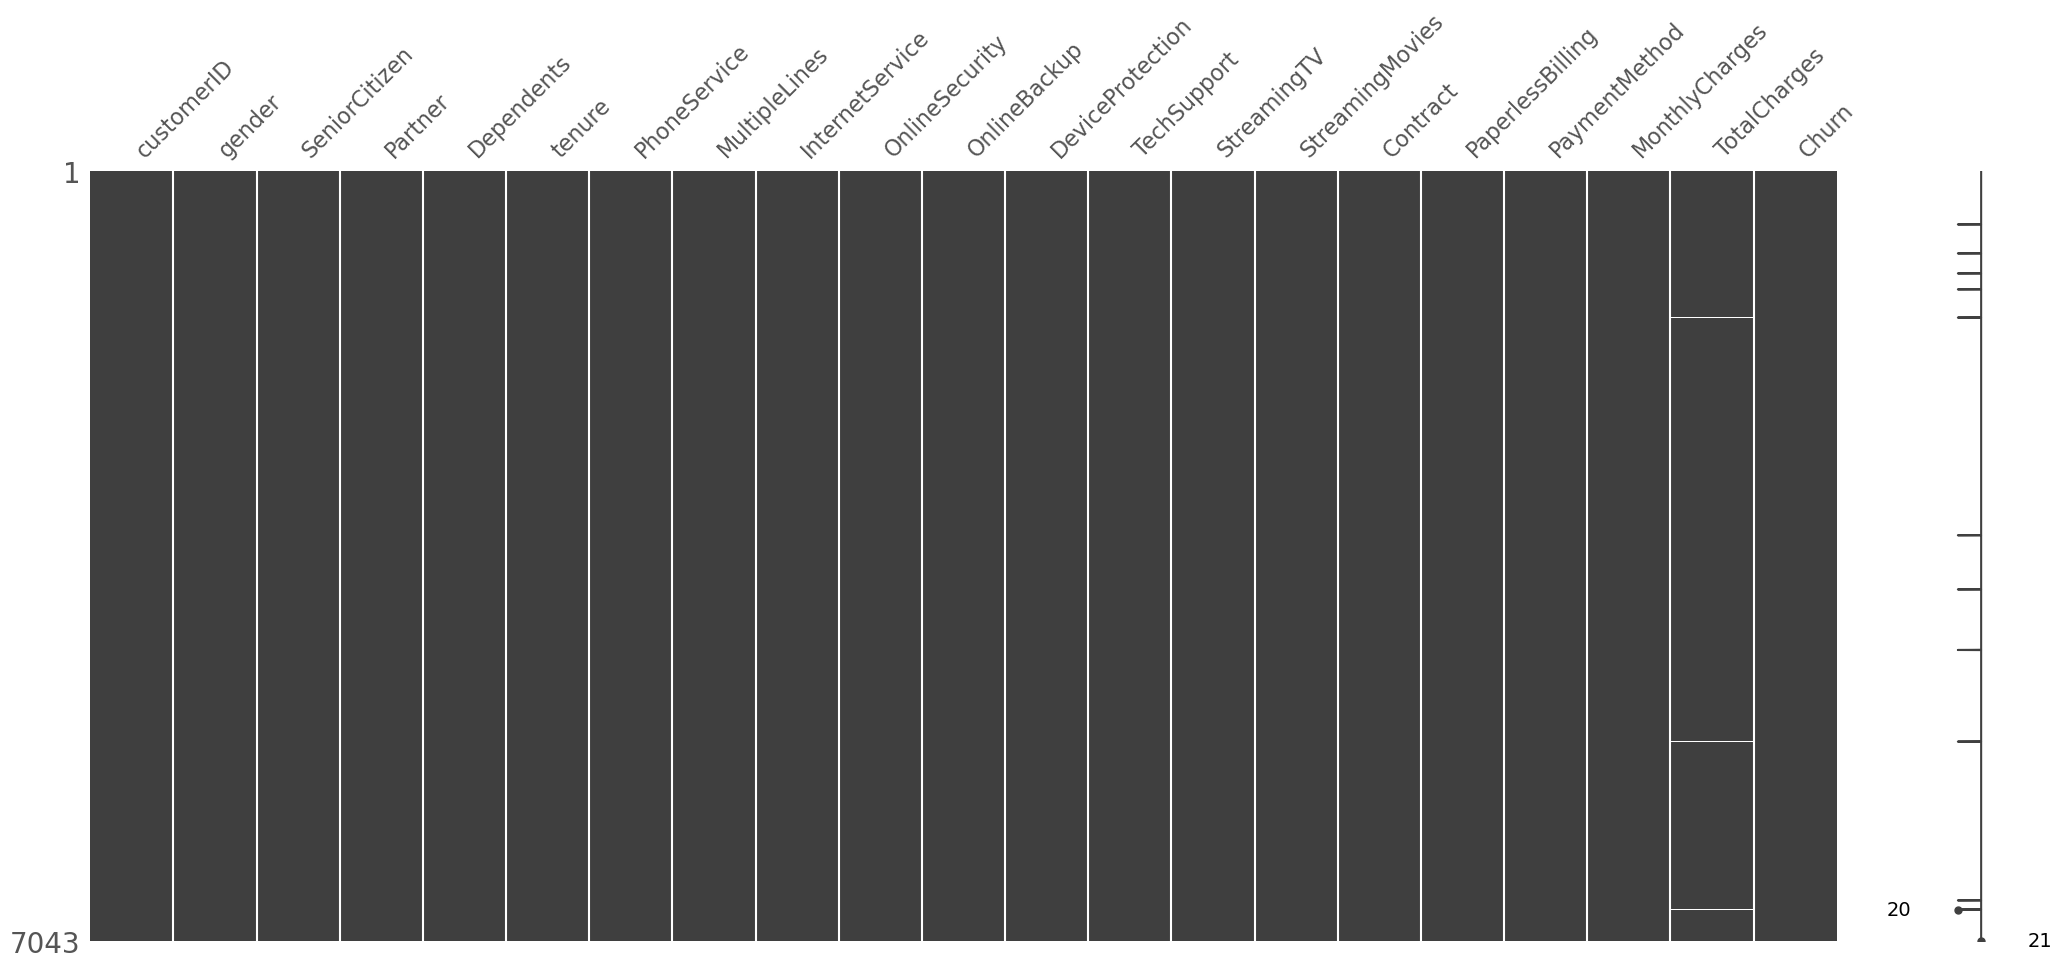

In [11]:
# Visualizing the missing data
import missingno as msno

# Visualize nullity patterns
msno.matrix(df)

plt.show()

To solve the problem of missing values in TotalCharges column, we will fill it with the mean of TotalCharges values.

In [12]:
# Fill the NAs in TotalCharges with the mean TotalCharges values.

df = df.fillna(df["TotalCharges"].mean())

In [13]:
# Verify
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [14]:
# Descriptive statistic of categorical columns
df.describe(include=["object", "bool"])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


Based on the description statistics of the categorical features above, here are some observations:
- Customer ID: There are 7043 unique customer IDs, which means there are many customers in the dataset.
- Gender: There are two genders represented in the data, with "Male" being the most frequent (3555).
- Partner: The majority of customers (3641) do not have a partner.
- Dependents: The majority of customers (4933) do not have dependents.
- PhoneService: Most customers (6361) have phone service.
- MultipleLines: There are 3 unique values, with the most frequent value for multiple lines being "No" (3390)
- InternetService: The most frequent internet service is "Fiber optic" (3096).
- OnlineSecurity: The most frequent value for online security is "No" (3498)
- OnlineBackup: The most frequent value for online backup is "No" (3088)
- DeviceProtection: The most frequent value for device protection is "No" (3090).
- TechSupport: The most frequent value for tech support is "No" (3473).
- StreamingTV: The majority of customers (2785) do not have streaming TV.
- StreamingMovies: The most frequent value for streaming movies is "No" (2773), followed by "Yes" (2965) and "No internet service" (1272).
- Contract: The most frequent contract type is "Month-to-month" (3875).
- PaperlessBilling: Most customers (4171) use paperless billing.
- PaymentMethod: The most frequent payment method is "Electronic check" (2365)
- Churn: The majority of customers (5174) did not churn.

In [15]:
# Descriptive statistic of numerical columns
df.describe(include=["int64", "float64"])

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Based on the description statistics of the numerical features above, here are some observations:

- Seniorcitizen: The table shows that 16.3% of the customers are senior citizens.
- Tenure: The average customer tenure is 32 months. The tenure ranges from 1 month to 72 months
- MonthlyCharges: The average monthly charge is 64.89. The monthly charges range from 18.25 to $118.75
- TotalCharges: The average total charge is 2,283.30. The total charges range from 18.80 to 8684.80.

### Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in any data analysis project. It involves summarizing the main characteristics of the data and visualizing them to gain insights.

For this project, we will explore the data and answer key business questions, such as:
- Which factors are most predictive of customer churn?
  - Understanding the key drivers of churn can help in developing more effective retention strategies.

- How does the churn rate vary by demographic segments or service types?
  - This will identify high-risk segments that require targeted interventions.

- What is the impact of billing methods and contract types on customer loyalty?
  - Insights into how different aspects of the service agreement affect churn can guide adjustments in service offerings.

- What is the potential revenue impact of reducing churn by specific percentages?
  - Understanding the financial benefits of churn reduction efforts can help justify the investment in predictive analytics and retention strategies.


In [16]:
df.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5422,3563-SVYLG,Male,0,Yes,Yes,68,Yes,No,DSL,Yes,...,Yes,Yes,No,No,Two year,No,Credit card (automatic),62.65,4375.80,No
4323,3707-LRWZD,Female,0,No,No,32,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,One year,No,Electronic check,84.05,2781.85,Yes
4046,0440-QEXBZ,Female,0,No,No,44,Yes,Yes,DSL,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,50.15,2139.10,No


In [17]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

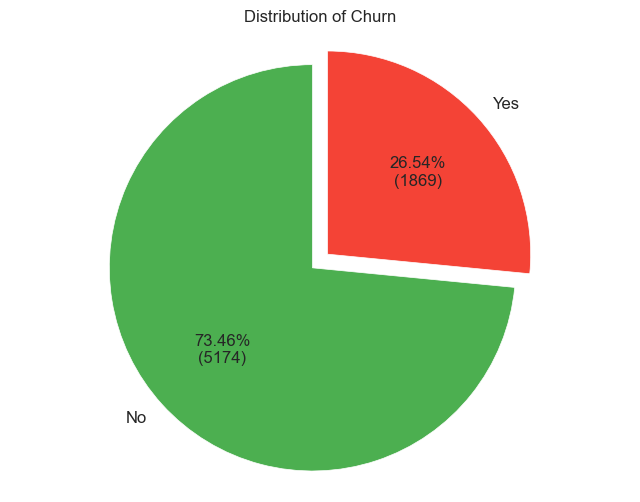

In [18]:

sns.set_style('darkgrid')
churn_counts = df['Churn'].value_counts()
colors = ['#4CAF50', '#F44336']  
labels = churn_counts.index
explode = (0.1, 0)  

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_format

# Creating the pie chart
plt.figure(figsize=(8,6))
plt.pie(churn_counts, explode=explode, labels=labels, colors=colors, autopct=autopct_format(churn_counts), startangle=90, textprops={'fontsize': 12})
plt.title('Distribution of Churn', fontsize = 12)
plt.axis('equal');

The majority of customers did not churn.

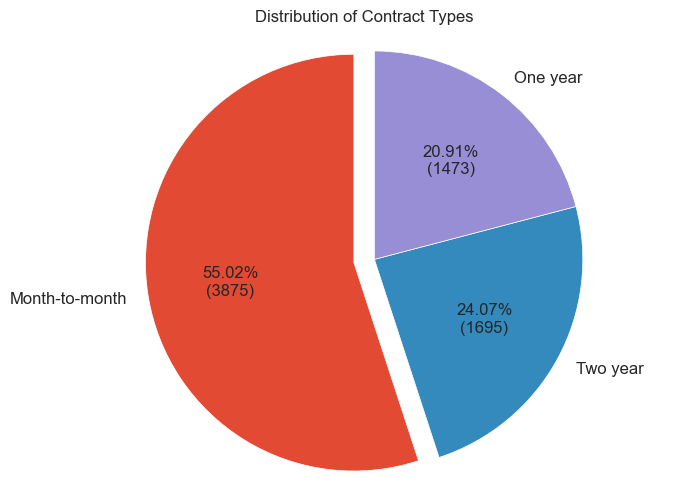

In [19]:
contract_counts = df['Contract'].value_counts()
labels = contract_counts.index
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  

# Creating the pie chart

plt.figure(figsize=(8,6))
plt.pie(contract_counts, explode=explode, labels=labels, autopct=autopct_format(contract_counts), startangle=90,textprops={'fontsize': 12})
plt.title('Distribution of Contract Types',fontsize = 12)
plt.axis('equal');

The majority of customers signed month-to-month contract (54.96%), while longer-term contracts of one and two years are less frequent.

##### Bivariate analysis

- Bivariate analysis of Categorical features

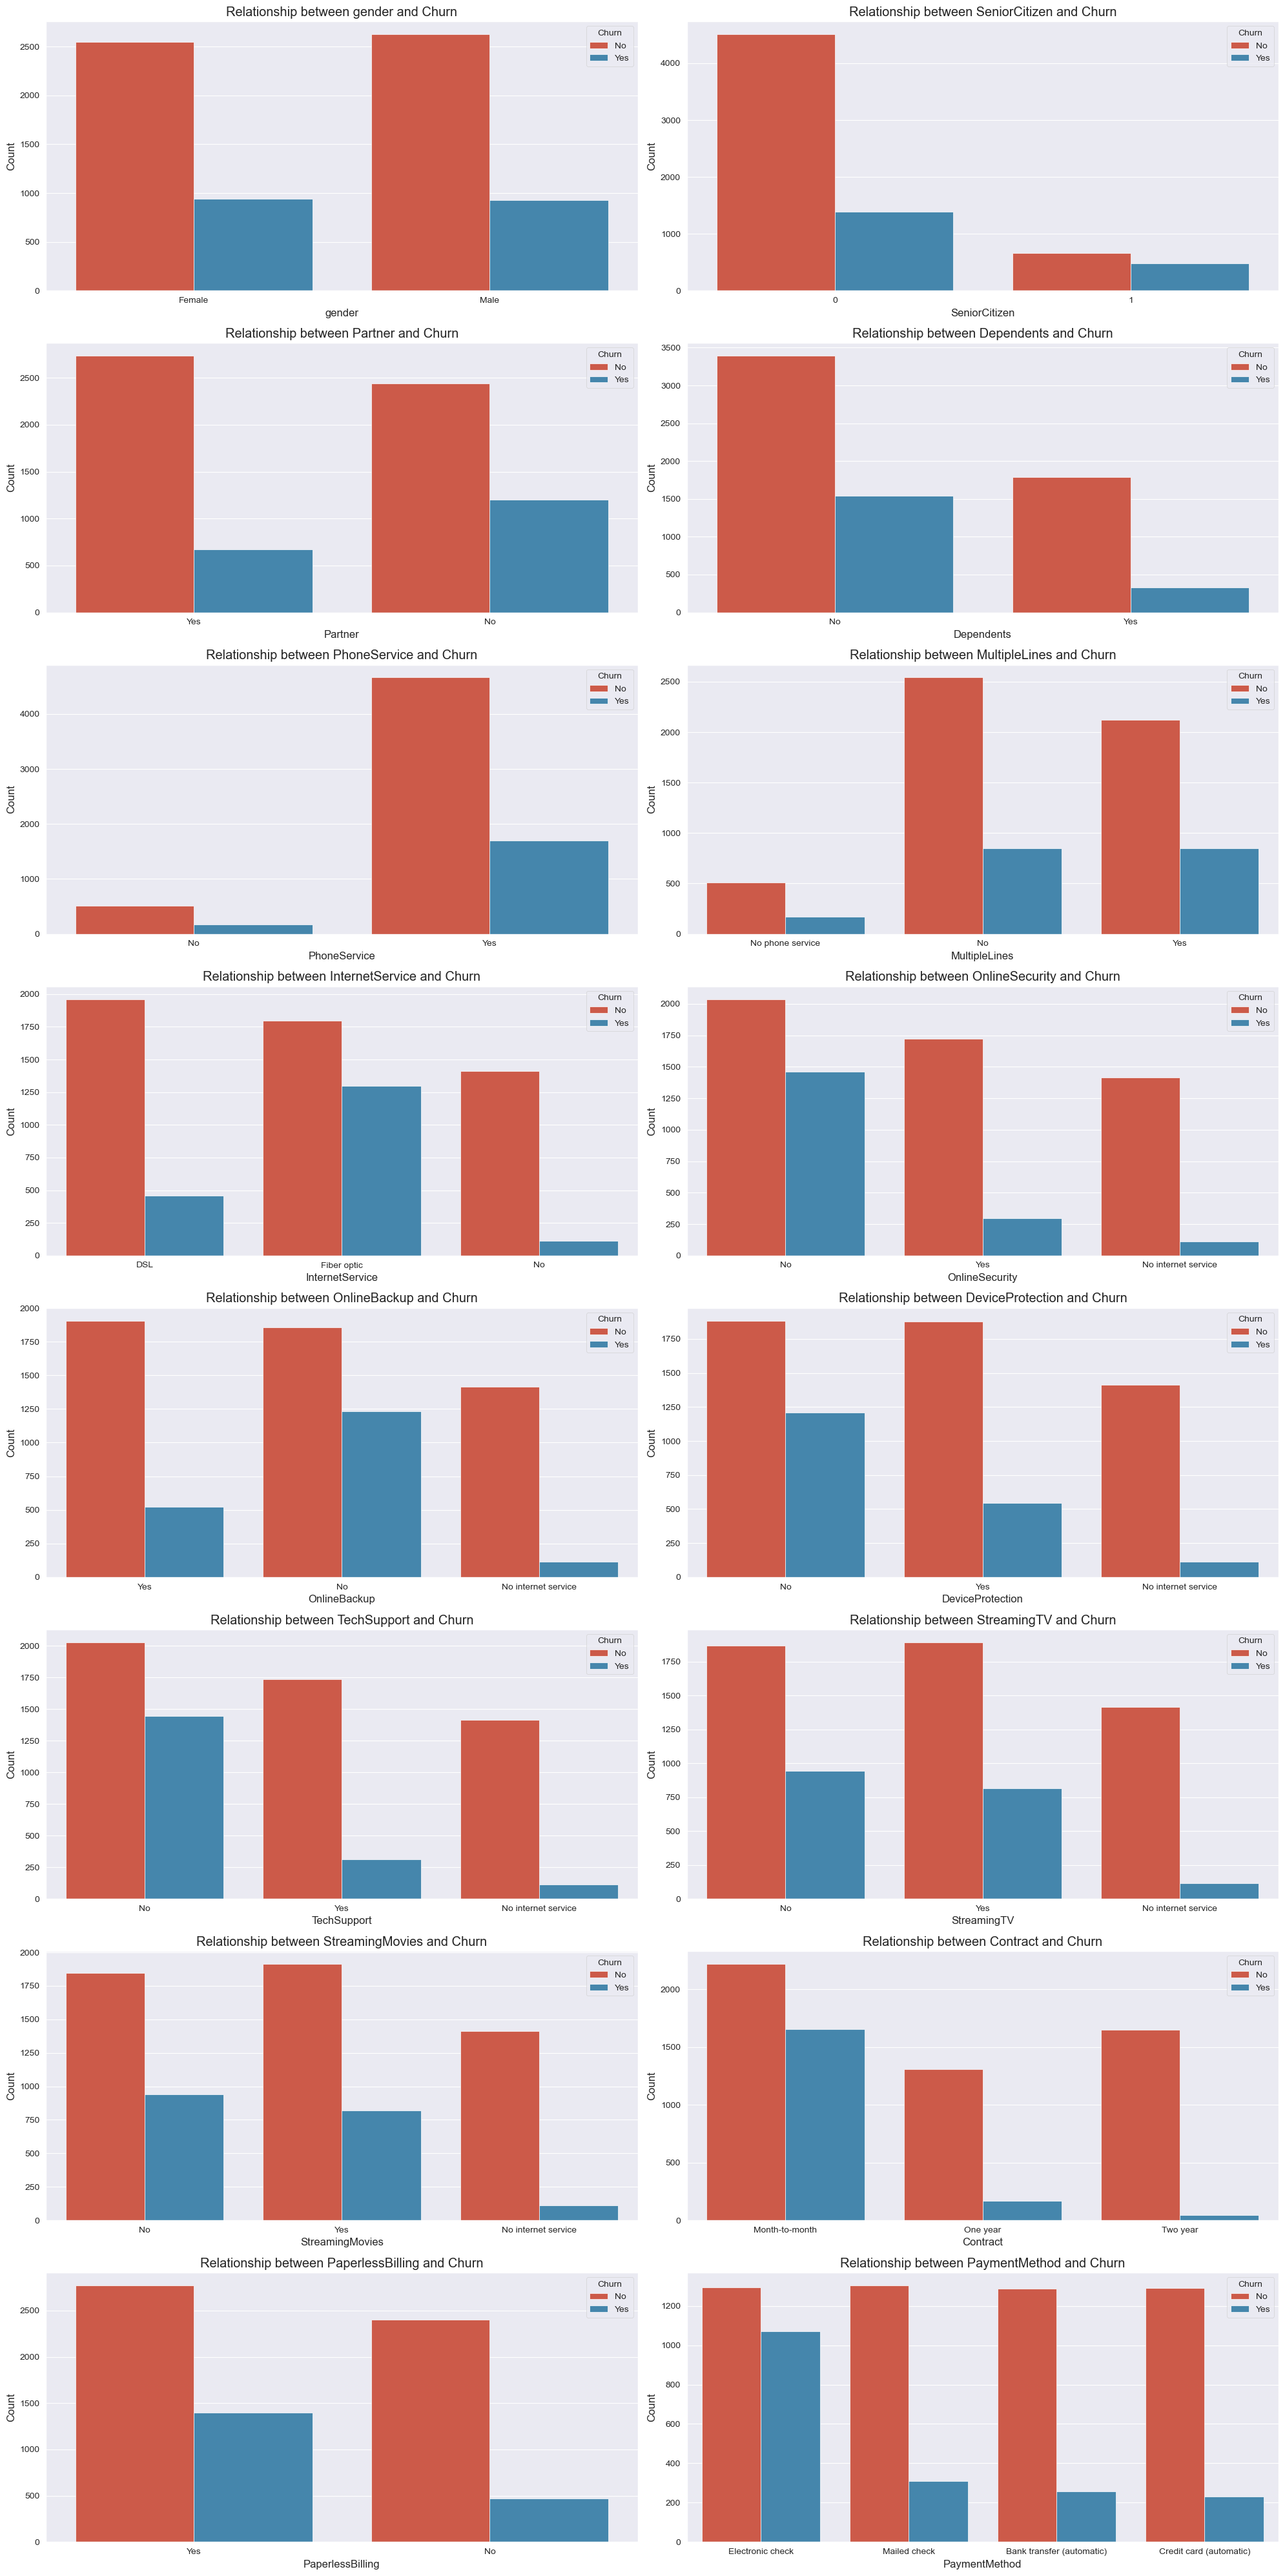

In [20]:
# List of categorical features

categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 40))
axes = axes.flatten()

# Plot bar plots for each categorical feature
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'Relationship between {feature} and Churn')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


- **Gender:** The churn rate appears to be fairly similar between male and female customers.
  - Implication: Gender does not seem to be a significant factor in predicting churn.
- **SeniorCitizen:** Senior citizens show a higher churn rate compared to non-senior citizens.
  -Implication: Senior citizens may require different retention strategies, potentially focusing on ease of use and tailored services.
- **Partner:** Customers without partners have a higher churn rate compared to those with partners.
  - Implication: Partner status could be indicative of stability and longer-term commitment, suggesting that customers without partners might need more attention to prevent churn.
- **Dependents:** Customers without dependents are more likely to churn than those with dependents.
  - Implication: Similar to the partner status, having dependents might correlate with a more stable customer base.
- **PhoneService:** There is no clear difference in churn rates between customers who have phone service and those who don't.
  - Implication: Phone service alone is not a significant predictor of churn.
- **MultipleLines:** Customers with multiple lines seem to have a higher churn rate compared to those with a single line or no phone service.
  - Implication: Managing multiple lines might be cumbersome, leading to dissatisfaction and churn.
- **InternetService:** Customers with fiber optic internet service have a higher churn rate compared to those with DSL or no internet service.
  - Implication: Fiber optic service might have issues leading to dissatisfaction, or it might attract a customer segment that is more price-sensitive or has higher expectations.
- **OnlineSecurity:** Customers without online security services have a higher churn rate.
  - Implication: Online security is a valuable service, and lack thereof could lead to dissatisfaction.
- **OnlineBackup:** Customers without online backup services have a higher churn rate.
  - Implication: Online backup services are also important for customer retention.
- **DeviceProtection:** Customers without device protection have a higher churn rate.
  - Implication: Device protection is another valued service that impacts customer retention.
- **TechSupport:** Customers without tech support have a higher churn rate.
  - Implication: Access to tech support is crucial for customer satisfaction and retention.
- **StreamingTV:** Customers without streaming TV services have a higher churn rate.
  - Implication: Streaming TV services are important for customer retention.
- **StreamingMovies:** Customers without streaming movie services have a higher churn rate.
  - Implication: Similar to streaming TV, streaming movies services are also important for retention.
- **Contract:** Customers with month-to-month contracts have a significantly higher churn rate compared to those with one-year or two-year contracts.
  - Implication: Longer-term contracts are effective in reducing churn, suggesting that encouraging customers to commit to longer contracts might help in retention.
- **PaperlessBilling:** Customers with paperless billing have a slightly higher churn rate.
  - Implication: Paperless billing alone does not significantly impact churn, but it may correlate with other factors such as convenience preferences.
- **PaymentMethod:** Customers who pay by electronic check have a higher churn rate compared to those who use other payment methods (bank transfer, credit card, mailed check).
  - Implication: The electronic check payment method might be less convenient or associated with a customer segment that is more likely to churn.

- Bivariate analysis of numerical features

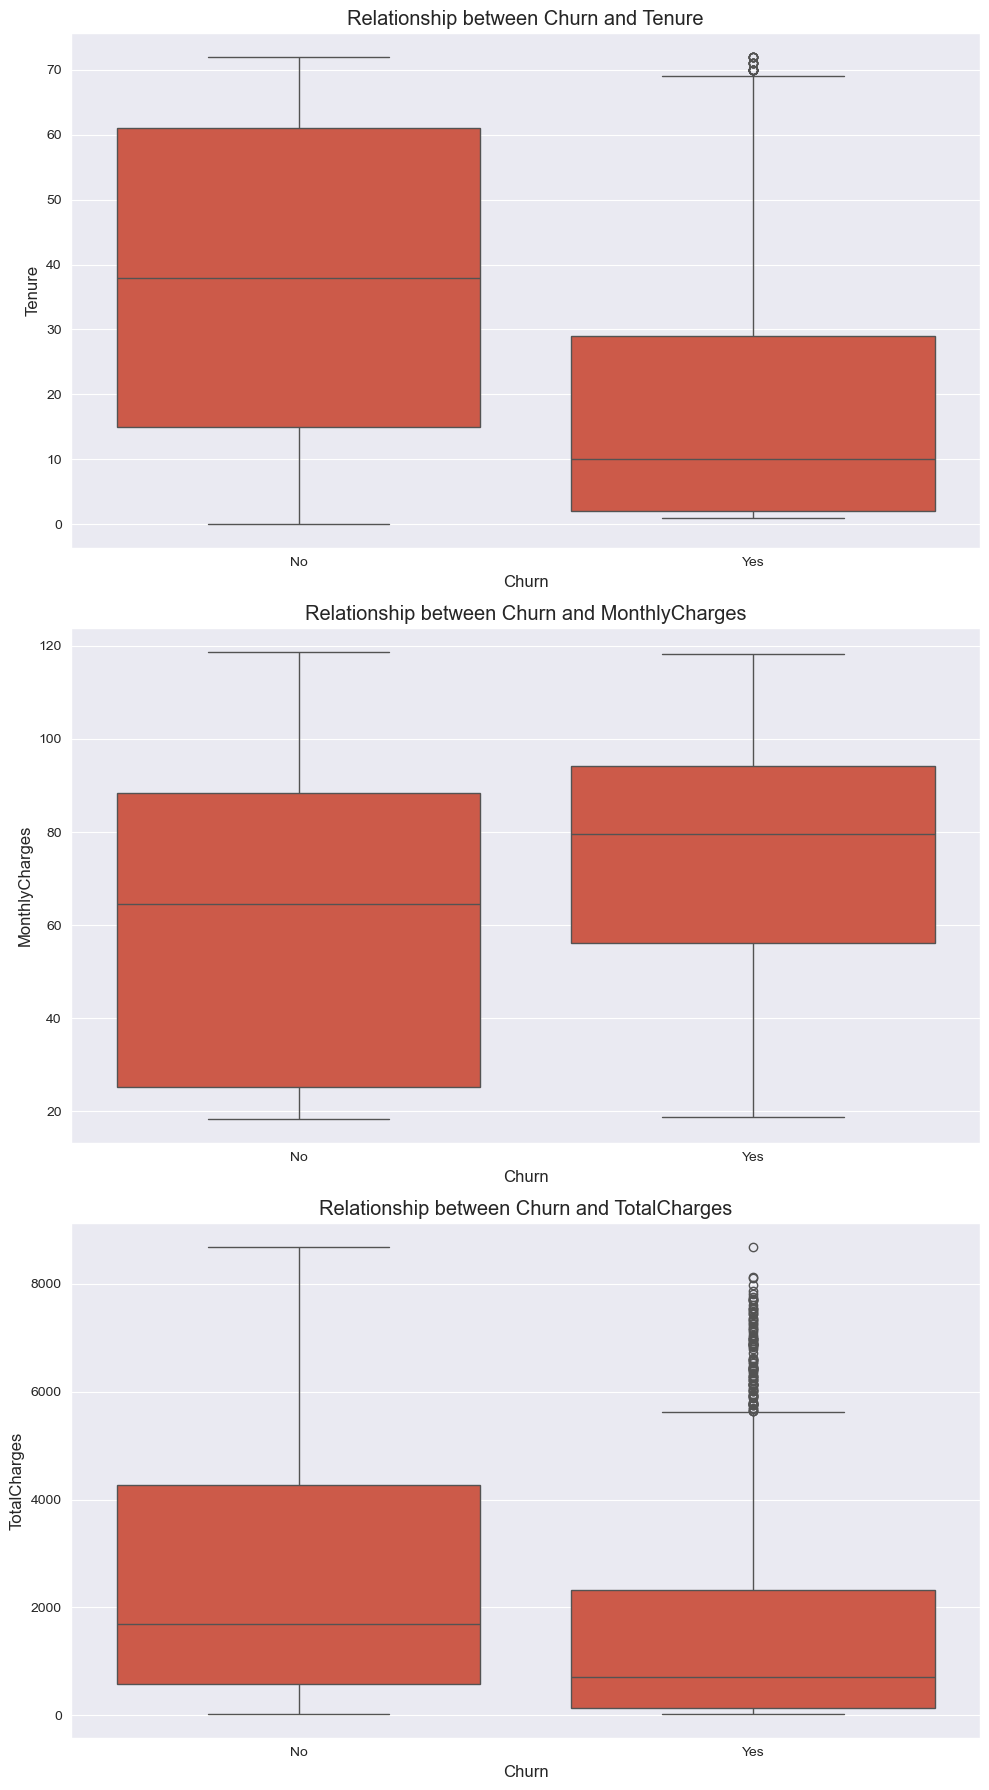

In [21]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Visualize the relationship between Churn and tenure
sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0])
axes[0].set_title('Relationship between Churn and Tenure')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Tenure')

# Visualize the relationship between Churn and MonthlyCharges
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1])
axes[1].set_title('Relationship between Churn and MonthlyCharges')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('MonthlyCharges')

# Visualize the relationship between Churn and TotalCharges
sns.boxplot(x='Churn', y='TotalCharges', data=df, ax=axes[2])
axes[2].set_title('Relationship between Churn and TotalCharges')
axes[2].set_xlabel('Churn')
axes[2].set_ylabel('TotalCharges')

# Adjust layout
plt.tight_layout()
plt.show()


- The boxplot shows that customers with shorter tenure are more likely to churn compared to those with longer tenure.
- Customers with higher monthly charges appear to have a higher likelihood of churning.
- The distribution of total charges does not show a clear trend with respect to churn, but customers with lower total charges (indicating shorter tenure and/or lower monthly charges) are somewhat more likely to churn.

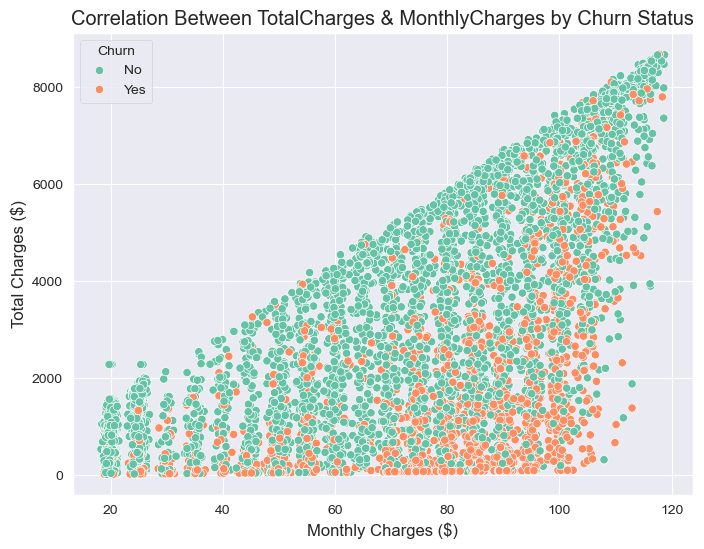

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', hue='Churn', data=df, palette='Set2')
plt.title('Correlation Between TotalCharges & MonthlyCharges by Churn Status')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Total Charges ($)')
plt.legend(title='Churn')

plt.show()

- **General Trend:**
  - There is a clear positive correlation between MonthlyCharges and TotalCharges. As monthly charges increase, total charges also increase. This is expected since TotalCharges is essentially the sum of MonthlyCharges over time.

- **Churn Distribution:**
  - Customers who have churned (orange dots) are more dispersed across different ranges of MonthlyCharges and TotalCharges compared to those who haven't churned (green dots).

- **Low MonthlyCharges and TotalCharges:**
  - At lower MonthlyCharges (e.g., less than $40), churned customers are more prevalent, especially for lower TotalCharges as well. This suggests that customers with lower monthly charges and lower total charges are more likely to churn.

- **High MonthlyCharges:**
  - For higher MonthlyCharges (e.g., above $80), churned customers are still present but tend to have higher TotalCharges. This indicates that some customers with high monthly charges are also prone to churn, despite having higher total charges.

- **Customer Tenure:**
  - Customers with low TotalCharges and high MonthlyCharges are likely to be newer customers who are at risk of churning early. Conversely, customers with high TotalCharges and moderate to high MonthlyCharges might be long-term customers who are at risk of churn.